# GARCH Density Training Notebook

This notebook trains a GMM MDN on the GARCH CDF densities dataset from Hugging Face.

In [1]:
from datasets import load_dataset


ds = load_dataset("sitmo/garch_densities", token=False)
print(ds) 

train = ds["train"]
test = ds["test"]

print(f"Train size: {len(train)} | Test size: {len(test)}")
print(f"Features: {train.features}")

/Users/thijs/Library/Caches/pypoetry/virtualenvs/density-engine-GEC8AyR8-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['alpha', 'gamma', 'beta', 'var0', 'eta', 'lam', 'ti', 'p', 'x'],
        num_rows: 7544274
    })
    test: Dataset({
        features: ['alpha', 'gamma', 'beta', 'var0', 'eta', 'lam', 'ti', 'p', 'x'],
        num_rows: 1940171
    })
    sample: Dataset({
        features: ['alpha', 'gamma', 'beta', 'var0', 'eta', 'lam', 'ti', 'p', 'x'],
        num_rows: 1000
    })
})
Train size: 7544274 | Test size: 1940171
Features: {'alpha': Value('float32'), 'gamma': Value('float32'), 'beta': Value('float32'), 'var0': Value('float32'), 'eta': Value('float32'), 'lam': Value('float32'), 'ti': Value('float32'), 'p': Value('float32'), 'x': List(Value('float32'))}


In [ ]:
import torch
from torch.utils.data import DataLoader

param_cols = ["alpha","gamma","beta","var0","eta","lam","ti"]
cols = param_cols + ["x"]
train = train.with_format("torch", columns=cols)

loader = DataLoader(train, batch_size=256, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
batch = next(iter(loader))

params  = torch.stack([batch[c] for c in param_cols], dim=1)  # [B,7]
targets = batch["x"]                                          # [B,512]
print(params.shape, targets.shape)


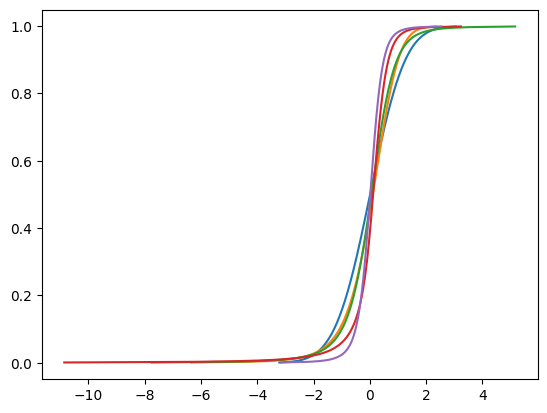

In [6]:
import matplotlib.pyplot as plt
import numpy as np
y = np.linspace(0.001, 0.999, 512)
for i in range(5):
    plt.plot(targets[i, :], y)
plt.show()

In [5]:
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

PARAM_COLS = ["alpha","gamma","beta","var0","eta","lam","ti"]
ALL_COLS   = PARAM_COLS + ["x"]

def log_ti_transform(ex):
    ex["ti"] = np.log(ex["ti"])
    return ex

def make_loader(ds, split, batch_size=512, workers=0):  # macOS: workers=0; Linux: try 4–8
    d = ds[split].with_transform(log_ti_transform).with_format("numpy", columns=ALL_COLS)

    def collate(batch):
        b = {k: np.stack([ex[k] for ex in batch]) for k in ALL_COLS}
        params  = torch.from_numpy(np.stack([b[c] for c in PARAM_COLS], axis=1))
        targets = torch.from_numpy(b["x"])
        return params.float(), targets.float()

    pin = torch.cuda.is_available()
    return DataLoader(
        d, batch_size=batch_size, shuffle=(split=="train"),
        num_workers=workers, pin_memory=pin,
        persistent_workers=bool(workers),
        prefetch_factor=(2 if workers else None),
        collate_fn=collate
    )

# ---- setup ----
ds = load_dataset("sitmo/garch_densities", token=False)
train_loader = make_loader(ds, "train", batch_size=2048, workers=0)  # bump batch_size if RAM allows
test_loader  = make_loader(ds, "test",  batch_size=2048, workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
non_block = device.type == "cuda"

def to_device(params, x):
    return params.to(device, non_blocking=non_block), x.to(device, non_blocking=non_block)

# ---- warmup / benchmark (don’t recreate iterators each step) ----
train_it = iter(train_loader)
test_it  = iter(test_loader)

for _ in range(30):
    try:
        p_tr, x_tr = next(train_it)
    except StopIteration:
        train_it = iter(train_loader); p_tr, x_tr = next(train_it)
    try:
        p_te, x_te = next(test_it)
    except StopIteration:
        test_it = iter(test_loader); p_te, x_te = next(test_it)

    p_tr, x_tr = to_device(p_tr, x_tr)
    p_te, x_te = to_device(p_te, x_te)
    # print(p_tr.shape, x_tr.shape, "|", p_te.shape, x_te.shape)


In [6]:
for _ in range(30):
    try:
        p_tr, x_tr = next(train_it)
    except StopIteration:
        train_it = iter(train_loader); p_tr, x_tr = next(train_it)
    try:
        p_te, x_te = next(test_it)
    except StopIteration:
        test_it = iter(test_loader); p_te, x_te = next(test_it)

    p_tr, x_tr = to_device(p_tr, x_tr)
    p_te, x_te = to_device(p_te, x_te)
    print(p_tr.shape, x_tr.shape, "|", p_te.shape, x_te.shape)

torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([2048, 7]) torch.Size([2048, 512])
torch.Size([2048, 7]) torch.Size([2048, 512]) | torch.Size([